2024-06-06 01:38:59,040 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv
2024-06-06 01:38:59,040 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv


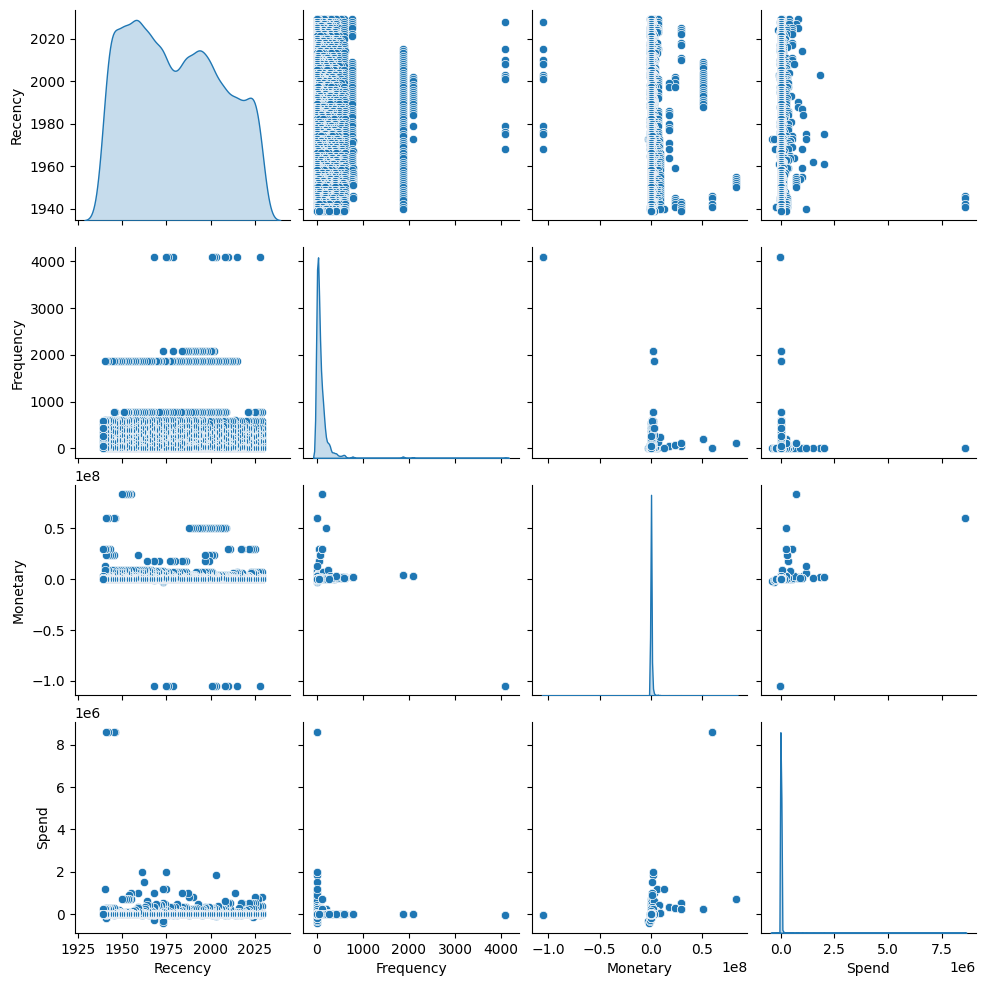

        CustomerId  Recency  Frequency   Monetary        Spend    RFMS_Score  \
0  CustomerId_4406     2029        119  109921.75   923.712185  28248.365546   
1  CustomerId_4683     2029          2    1000.00   500.000000    882.750000   
2   CustomerId_988     2029         38  228727.20  6019.136842  59203.334211   
3  CustomerId_1432     2029          1    2000.00  2000.000000   1507.500000   
4  CustomerId_2858     2029         29   93400.00  3220.689655  24669.672414   

  Label  
0   Bad  
1   Bad  
2  Good  
3   Bad  
4   Bad  


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('int64'), dtype('<U76577')) -> None

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

import sys
sys.path.append('..')

from src.data_loader import DataLoader
from src.eda import EDA
from src.feature_engineering import FeatureEngineering

# Load the data
data_loader = DataLoader('../data/raw/data.csv')
df = data_loader.load_data()

# Define RFMS variables
def calculate_rfms(df):
    # Convert TransactionStartTime to datetime and ensure timezone-naive
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime']).dt.tz_localize(None)
    
    # Recency: Days since last transaction
    df['Recency'] = (pd.to_datetime('today') - df['TransactionStartTime']).dt.days
    
    # Frequency: Number of transactions per customer
    df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')
    
    # Monetary: Total transaction amount per customer
    df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')
    
    # Spend: Average transaction amount per customer
    df['Spend'] = df.groupby('CustomerId')['Amount'].transform('mean')
    
    # Return RFMS DataFrame
    rfms = df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Spend']].drop_duplicates().reset_index(drop=True)
    return rfms

# Calculate RFMS variables
rfms_df = calculate_rfms(df)

# Visualize RFMS variables
sns.pairplot(rfms_df, diag_kind='kde')
plt.show()

# Establish a boundary for good and bad labels
# This example uses a simple threshold based on the median of the RFMS score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] + rfms_df['Frequency'] + rfms_df['Monetary'] + rfms_df['Spend']) / 4
threshold = rfms_df['RFMS_Score'].median()
rfms_df['Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the RFMS DataFrame with labels
print(rfms_df.head())

# Function to calculate WoE and IV
def calculate_woe_iv(df, feature, target):
    # Calculate the number of events and non-events
    total_events = df[target].sum()
    total_non_events = df[target].count() - total_events
    
    # Create a DataFrame to store WoE and IV
    woe_iv_df = pd.DataFrame()
    
    # Calculate WoE and IV for each bin
    for bin in df[feature].unique():
        bin_events = df[df[feature] == bin][target].sum()
        bin_non_events = df[df[feature] == bin][target].count() - bin_events
        woe = np.log((bin_events / total_events) / (bin_non_events / total_non_events))
        iv = (bin_events / total_events - bin_non_events / total_non_events) * woe
        woe_iv_df = woe_iv_df.append({'Feature': feature, 'Bin': bin, 'WoE': woe, 'IV': iv}, ignore_index=True)
    
    # Calculate total IV
    total_iv = woe_iv_df['IV'].sum()
    
    # Transform the feature using WoE
    woe_transformed = df[feature].map(woe_iv_df.set_index('Bin')['WoE'])
    
    return woe_transformed, total_iv

# Transform RFMS variables using WoE
for feature in ['Recency', 'Frequency', 'Monetary', 'Spend']:
    rfms_df[feature + '_WoE'], iv = calculate_woe_iv(rfms_df, feature, 'Label')
    print(f'Information Value (IV) for {feature}: {iv}')

# Prepare the data for logistic regression
X = rfms_df[['Recency_WoE', 'Frequency_WoE', 'Monetary_WoE', 'Spend_WoE']]
y = rfms_df['Label'].apply(lambda x: 1 if x == 'Good' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'AUC: {auc}')
print(f'Accuracy: {accuracy}')

2024-06-06 01:41:45,770 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv
2024-06-06 01:41:45,770 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv
2024-06-06 01:41:45,770 - src.logger - INFO - Data loaded successfully from ../data/raw/data.csv


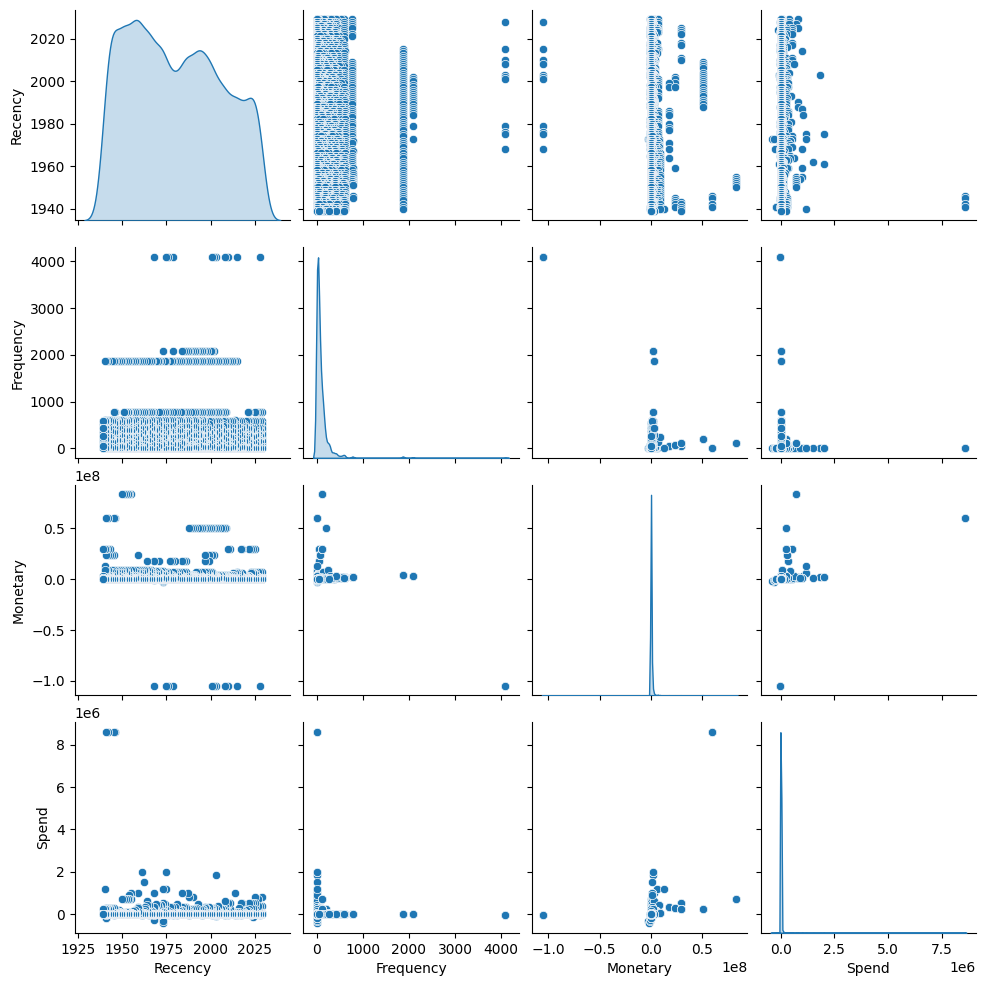

        CustomerId  Recency  Frequency   Monetary        Spend    RFMS_Score  \
0  CustomerId_4406     2029        119  109921.75   923.712185  28248.365546   
1  CustomerId_4683     2029          2    1000.00   500.000000    882.750000   
2   CustomerId_988     2029         38  228727.20  6019.136842  59203.334211   
3  CustomerId_1432     2029          1    2000.00  2000.000000   1507.500000   
4  CustomerId_2858     2029         29   93400.00  3220.689655  24669.672414   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0  


AttributeError: 'DataFrame' object has no attribute 'append'

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

import sys
sys.path.append('..')

from src.data_loader import DataLoader
from src.eda import EDA
from src.feature_engineering import FeatureEngineering

# Load the data
data_loader = DataLoader('../data/raw/data.csv')
df = data_loader.load_data()

# Define RFMS variables
def calculate_rfms(df):
    # Convert TransactionStartTime to datetime and ensure timezone-naive
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime']).dt.tz_localize(None)
    
    # Recency: Days since last transaction
    df['Recency'] = (pd.to_datetime('today') - df['TransactionStartTime']).dt.days
    
    # Frequency: Number of transactions per customer
    df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')
    
    # Monetary: Total transaction amount per customer
    df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')
    
    # Spend: Average transaction amount per customer
    df['Spend'] = df.groupby('CustomerId')['Amount'].transform('mean')
    
    # Return RFMS DataFrame
    rfms = df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Spend']].drop_duplicates().reset_index(drop=True)
    return rfms

# Calculate RFMS variables
rfms_df = calculate_rfms(df)

# Visualize RFMS variables
sns.pairplot(rfms_df, diag_kind='kde')
plt.show()

# Establish a boundary for good and bad labels
# This example uses a simple threshold based on the median of the RFMS score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] + rfms_df['Frequency'] + rfms_df['Monetary'] + rfms_df['Spend']) / 4
threshold = rfms_df['RFMS_Score'].median()
rfms_df['Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 1, 0)  # 1 for 'Good', 0 for 'Bad'

# Display the RFMS DataFrame with labels
print(rfms_df.head())

# Function to calculate WoE and IV
def calculate_woe_iv(df, feature, target):
    # Calculate the number of events and non-events
    total_events = df[target].sum()
    total_non_events = df[target].count() - total_events
    
    # Create a DataFrame to store WoE and IV
    woe_iv_df = pd.DataFrame(columns=['Feature', 'Bin', 'WoE', 'IV'])
    
    # Calculate WoE and IV for each bin
    for bin in df[feature].unique():
        bin_events = df[df[feature] == bin][target].sum()
        bin_non_events = df[df[feature] == bin][target].count() - bin_events
        woe = np.log((bin_events / total_events) / (bin_non_events / total_non_events))
        iv = (bin_events / total_events - bin_non_events / total_non_events) * woe
        woe_iv_df = pd.concat([woe_iv_df, pd.DataFrame({'Feature': [feature], 'Bin': [bin], 'WoE': [woe], 'IV': [iv]})], ignore_index=True)
    
    # Calculate total IV
    total_iv = woe_iv_df['IV'].sum()
    
    # Transform the feature using WoE
    woe_transformed = df[feature].map(woe_iv_df.set_index('Bin')['WoE'])
    
    return woe_transformed, total_iv

# Transform RFMS variables using WoE
for feature in ['Recency', 'Frequency', 'Monetary', 'Spend']:
    rfms_df[feature + '_WoE'], iv = calculate_woe_iv(rfms_df, feature, 'Label')
    print(f'Information Value (IV) for {feature}: {iv}')

# Prepare the data for logistic regression
X = rfms_df[['Recency_WoE', 'Frequency_WoE', 'Monetary_WoE', 'Spend_WoE']]
y = rfms_df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'AUC: {auc}')
print(f'Accuracy: {accuracy}')